## GeoAI Ground-level NO2 Estimation Challenge by ITU

### Author: Hubert Kłosowski 242424

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

### Load data

In [2]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86584 entries, 0 to 86583
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID_Zindi            86584 non-null  object 
 1   Date                86584 non-null  object 
 2   ID                  86584 non-null  object 
 3   LAT                 86584 non-null  float64
 4   LON                 86584 non-null  float64
 5   Precipitation       86584 non-null  float64
 6   LST                 46798 non-null  float64
 7   AAI                 73709 non-null  float64
 8   CloudFraction       73709 non-null  float64
 9   NO2_strat           73709 non-null  float64
 10  NO2_total           73709 non-null  float64
 11  NO2_trop            51111 non-null  float64
 12  TropopausePressure  73709 non-null  float64
 13  GT_NO2              82051 non-null  float64
dtypes: float64(11), object(3)
memory usage: 9.2+ MB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6576 entries, 0 to 6575
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID_Zindi            6576 non-null   object 
 1   Date                6576 non-null   object 
 2   ID                  6576 non-null   object 
 3   LAT                 6576 non-null   float64
 4   LON                 6576 non-null   float64
 5   Precipitation       6576 non-null   float64
 6   LST                 3595 non-null   float64
 7   AAI                 5708 non-null   float64
 8   CloudFraction       5708 non-null   float64
 9   NO2_strat           5708 non-null   float64
 10  NO2_total           5708 non-null   float64
 11  NO2_trop            3998 non-null   float64
 12  TropopausePressure  5708 non-null   float64
dtypes: float64(10), object(3)
memory usage: 668.0+ KB


### Extract date info

In [5]:
def extract_date_info(dataframe):
    dataframe['Date'] = pd.to_datetime(dataframe['Date'], format='mixed')
    dataframe['DayOfWeek'] = dataframe['Date'].dt.dayofweek.astype('category')
    dataframe['Month'] = dataframe['Date'].dt.month.astype('category')
    dataframe['Year'] = dataframe['Date'].dt.year.astype('category')
    dataframe['Week'] = dataframe['Date'].dt.isocalendar().week.astype('category')
    dataframe['Season'] = get_season(dataframe['Date']).astype('category')
    dataframe.drop(['Date'], axis=1, inplace=True)
    return dataframe

def get_season(date_series):
    spring = ((date_series.dt.month == 3) & (date_series.dt.day >= 20)) | ((date_series.dt.month > 3) & (date_series.dt.month < 6)) | ((date_series.dt.month == 6) & (date_series.dt.day <= 20))
    summer = ((date_series.dt.month == 6) & (date_series.dt.day >= 21)) | ((date_series.dt.month > 6) & (date_series.dt.month < 9)) | ((date_series.dt.month == 9) & (date_series.dt.day <= 22))
    autumn = ((date_series.dt.month == 9) & (date_series.dt.day >= 23)) | ((date_series.dt.month > 9) & (date_series.dt.month < 12)) | ((date_series.dt.month == 12) & (date_series.dt.day <= 20))
    
    season_series = pd.Series(0, index=date_series.index)  # Domyślnie 0 dla wiosny
    season_series.loc[summer] = 1  # Lato
    season_series.loc[autumn] = 2  # Jesień
    season_series.loc[~(spring | summer | autumn)] = 3  # Zima
    
    return season_series

train = extract_date_info(train)
test = extract_date_info(test)

### Target values in day of week

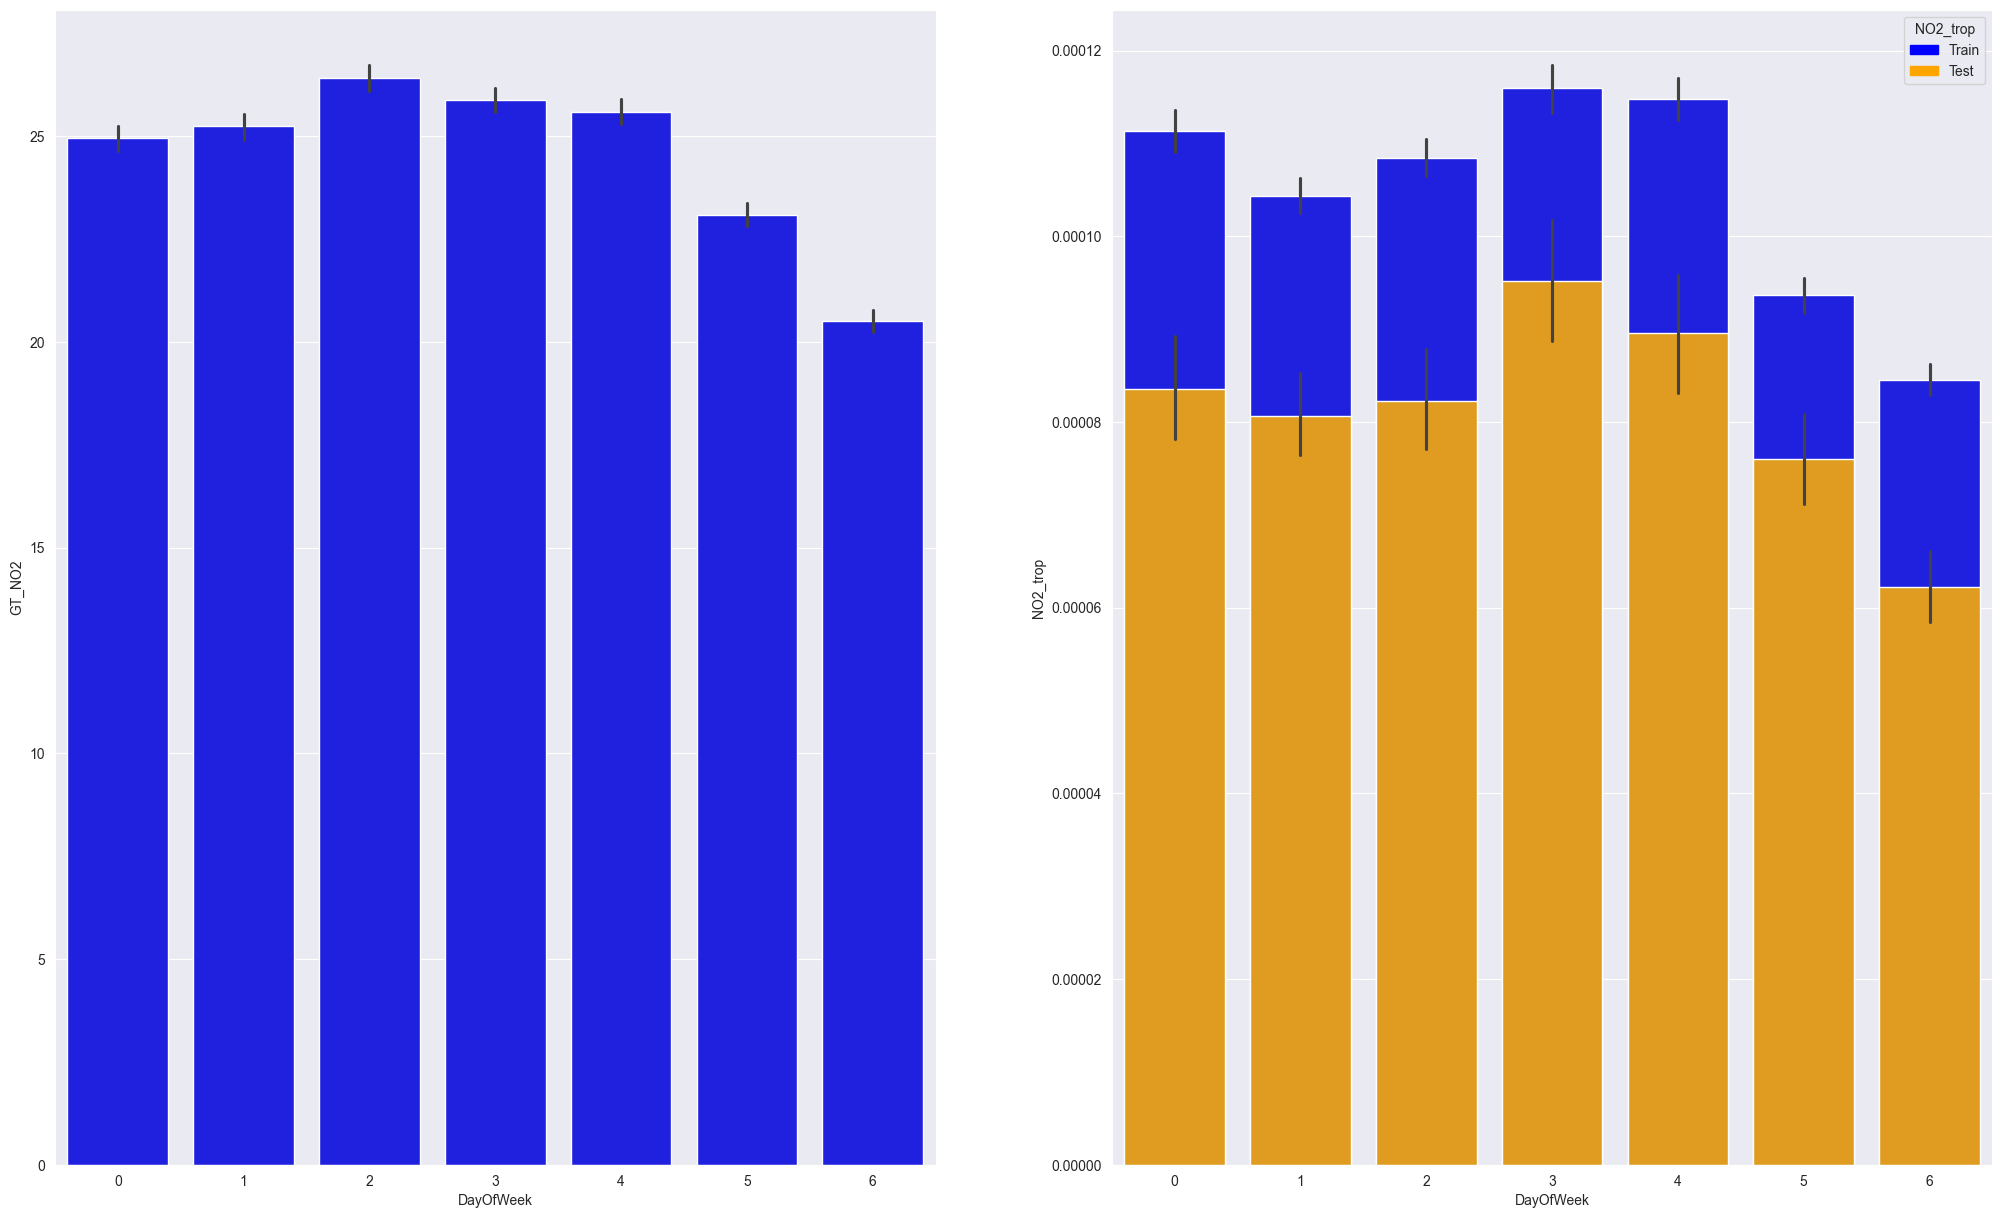

In [6]:
import matplotlib.patches as mpatches


def compare_plots(column_name):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 15))
    
    sns.barplot(data=train, x=column_name, y='GT_NO2', ax=ax[0], color='blue')
    sns.barplot(data=train, x=column_name, y='NO2_trop', ax=ax[1], color='blue')
    sns.barplot(data=test, x=column_name, y='NO2_trop', ax=ax[1], color='orange')
    
    train_patch = mpatches.Patch(color='blue', label='Train')
    test_patch = mpatches.Patch(color='orange', label='Test')
    
    ax[1].legend(handles=[train_patch, test_patch], title='NO2_trop', loc='upper right')
    plt.show()
    

compare_plots('DayOfWeek')

### Target values in months

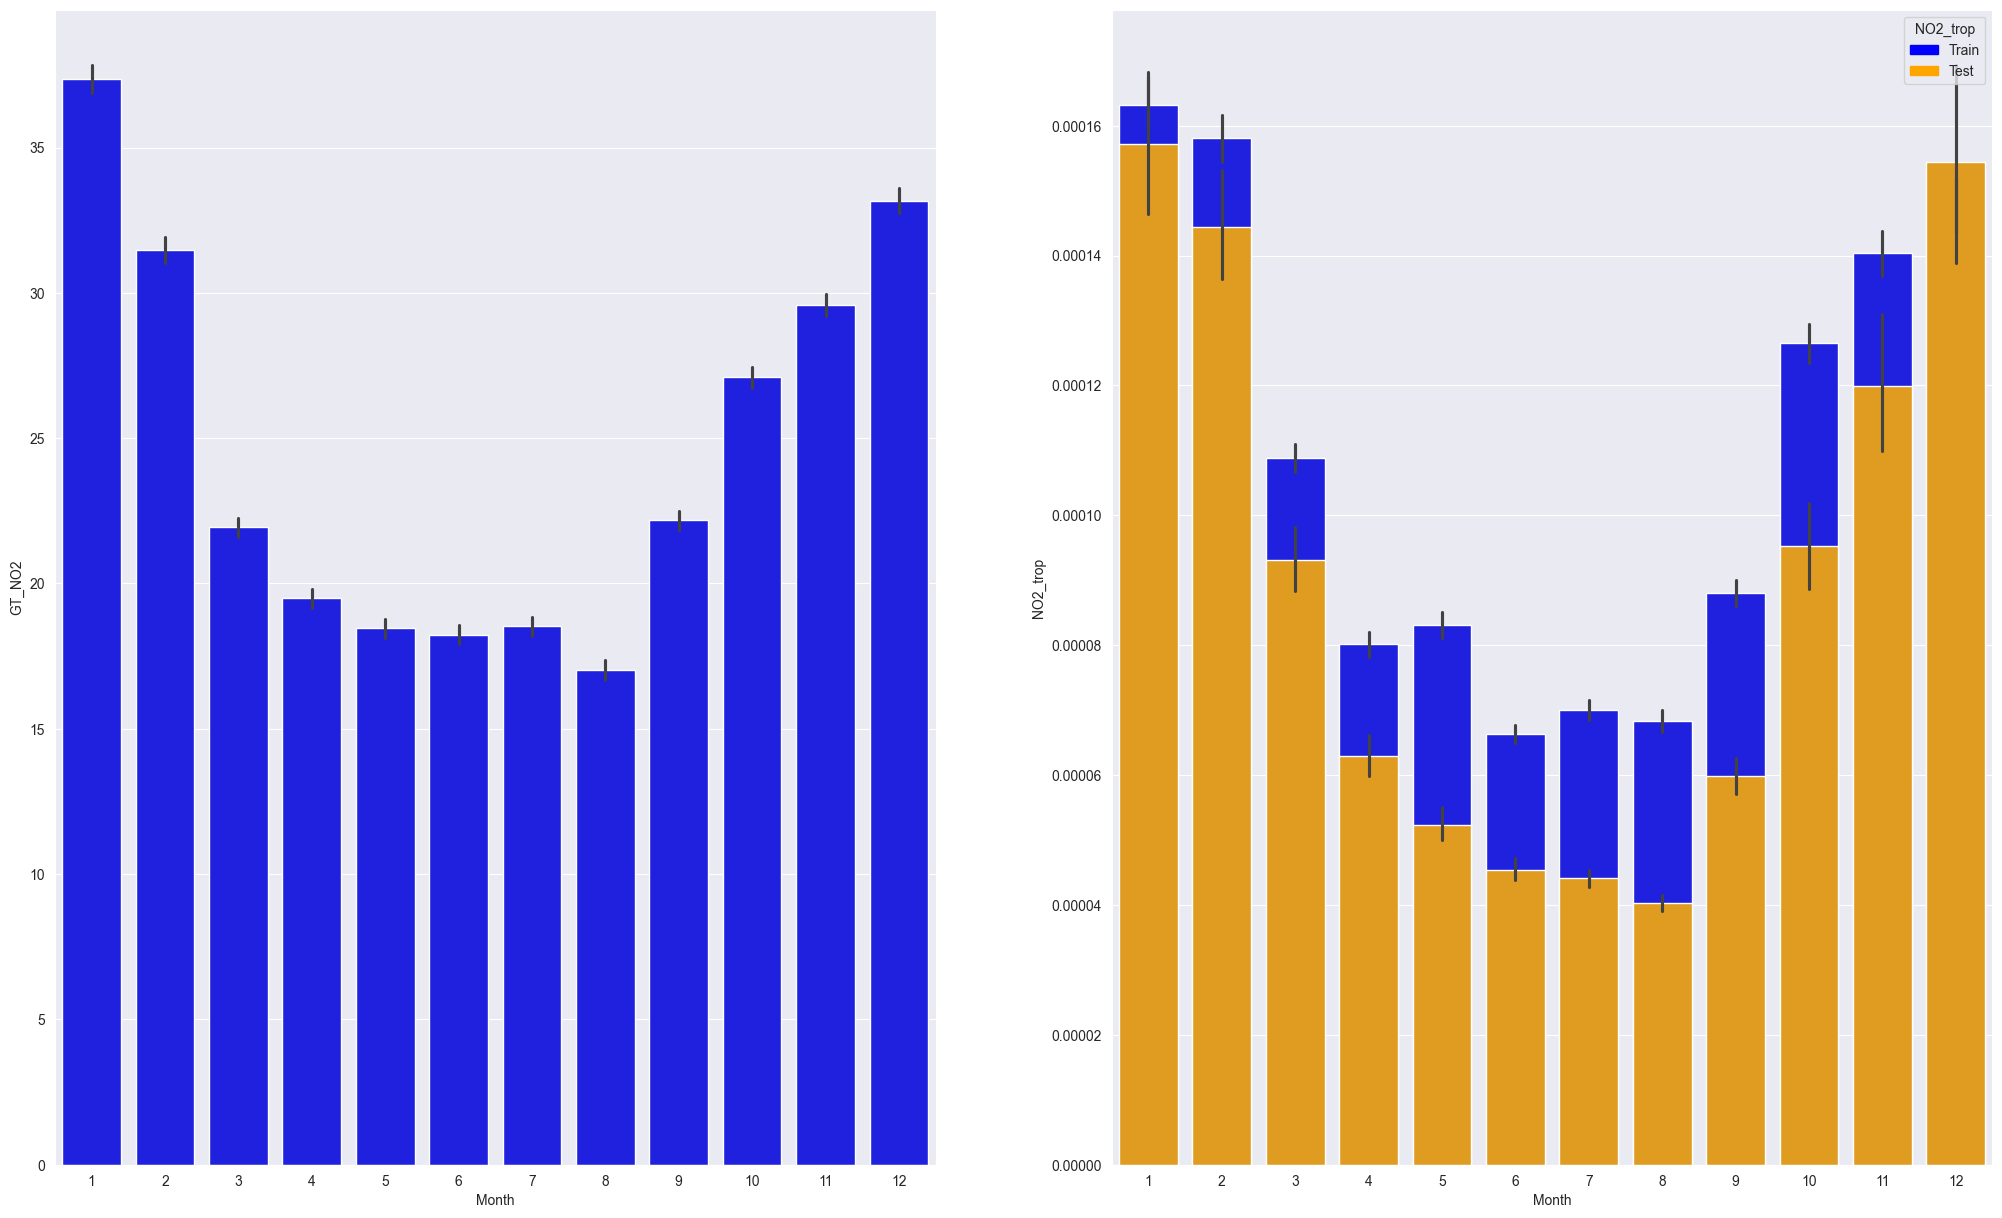

In [7]:
compare_plots('Month')

### Target values in years

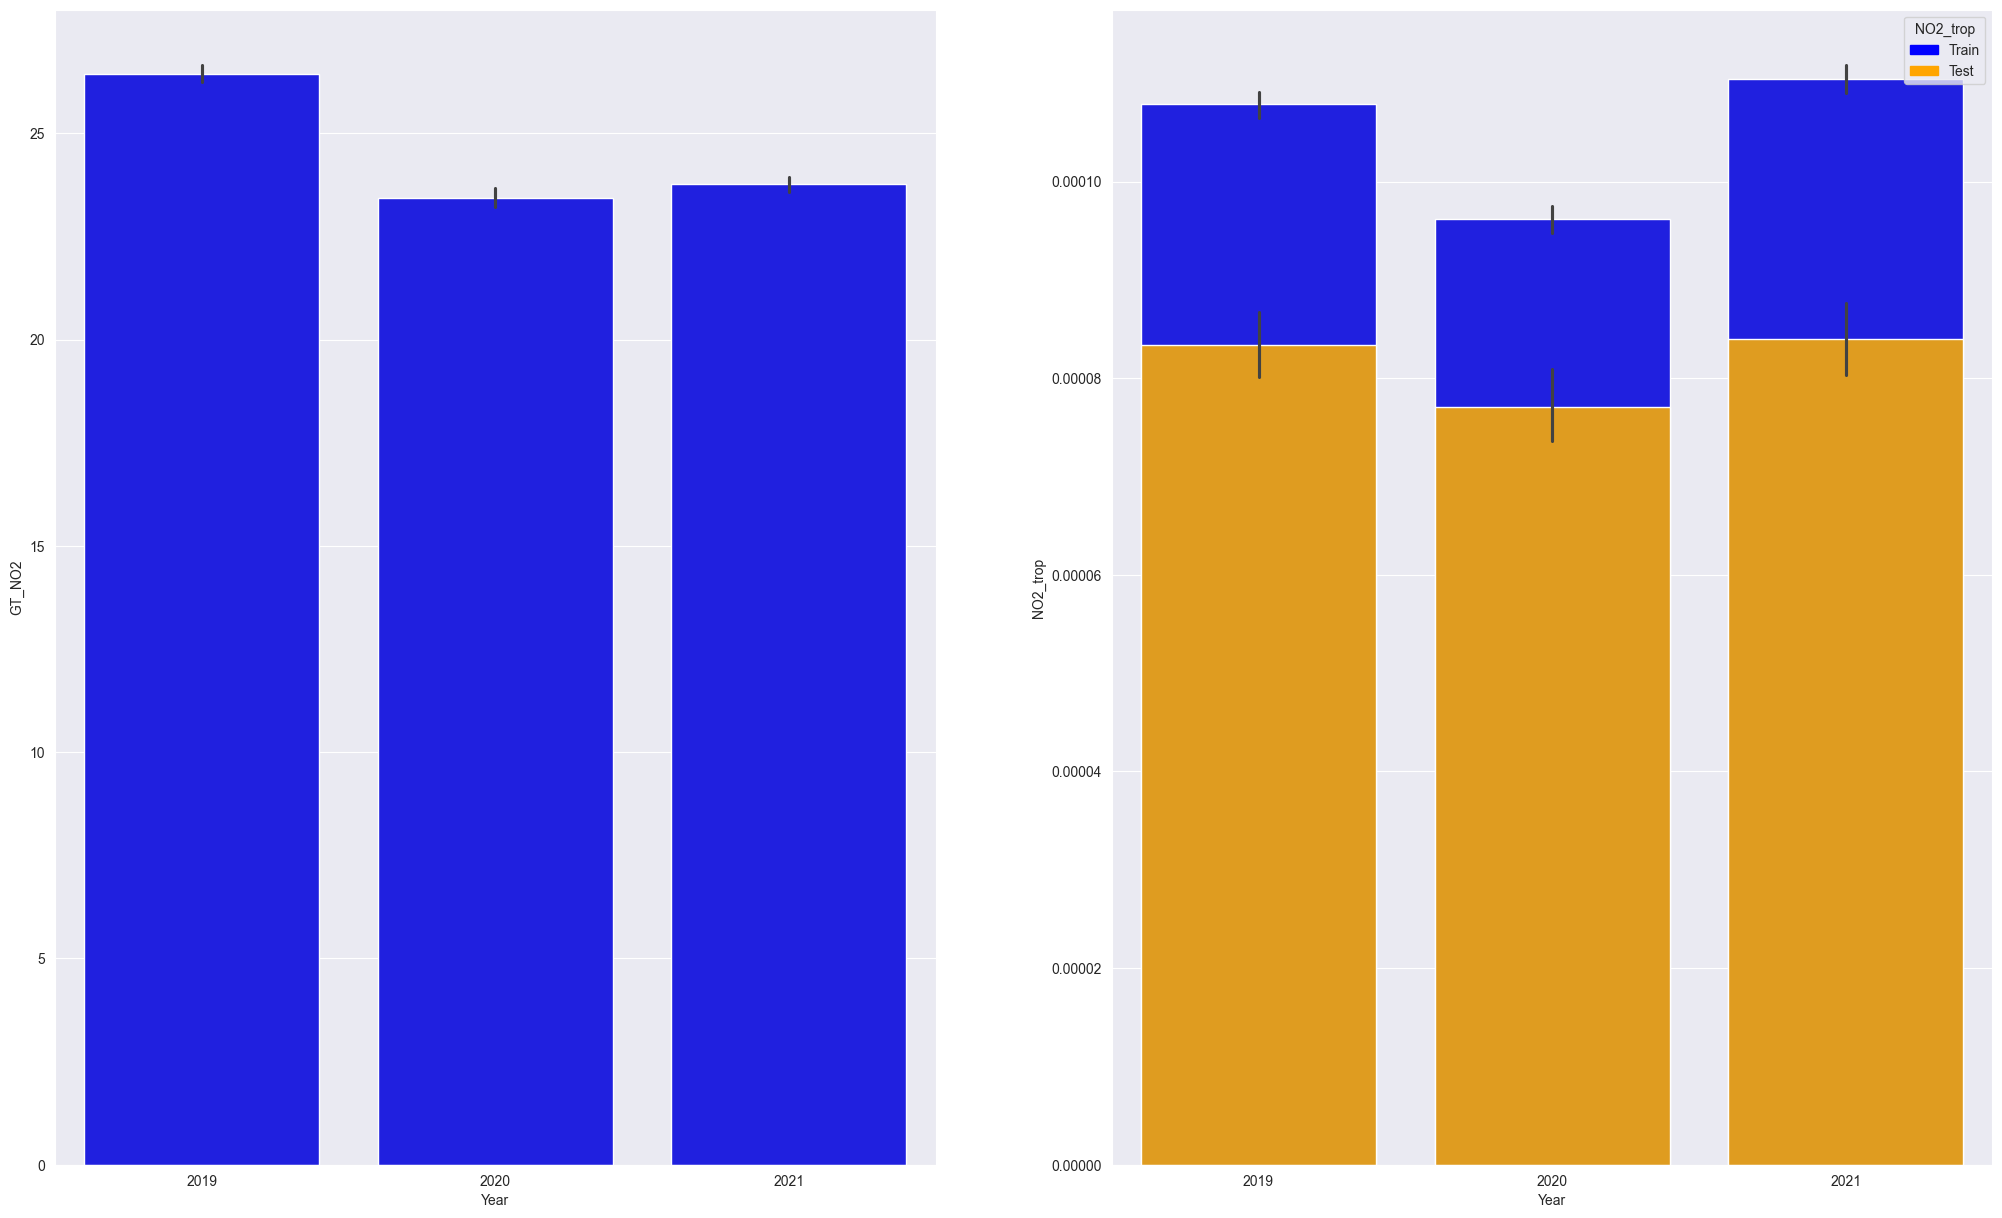

In [8]:
compare_plots('Year')

### Target values in weeks

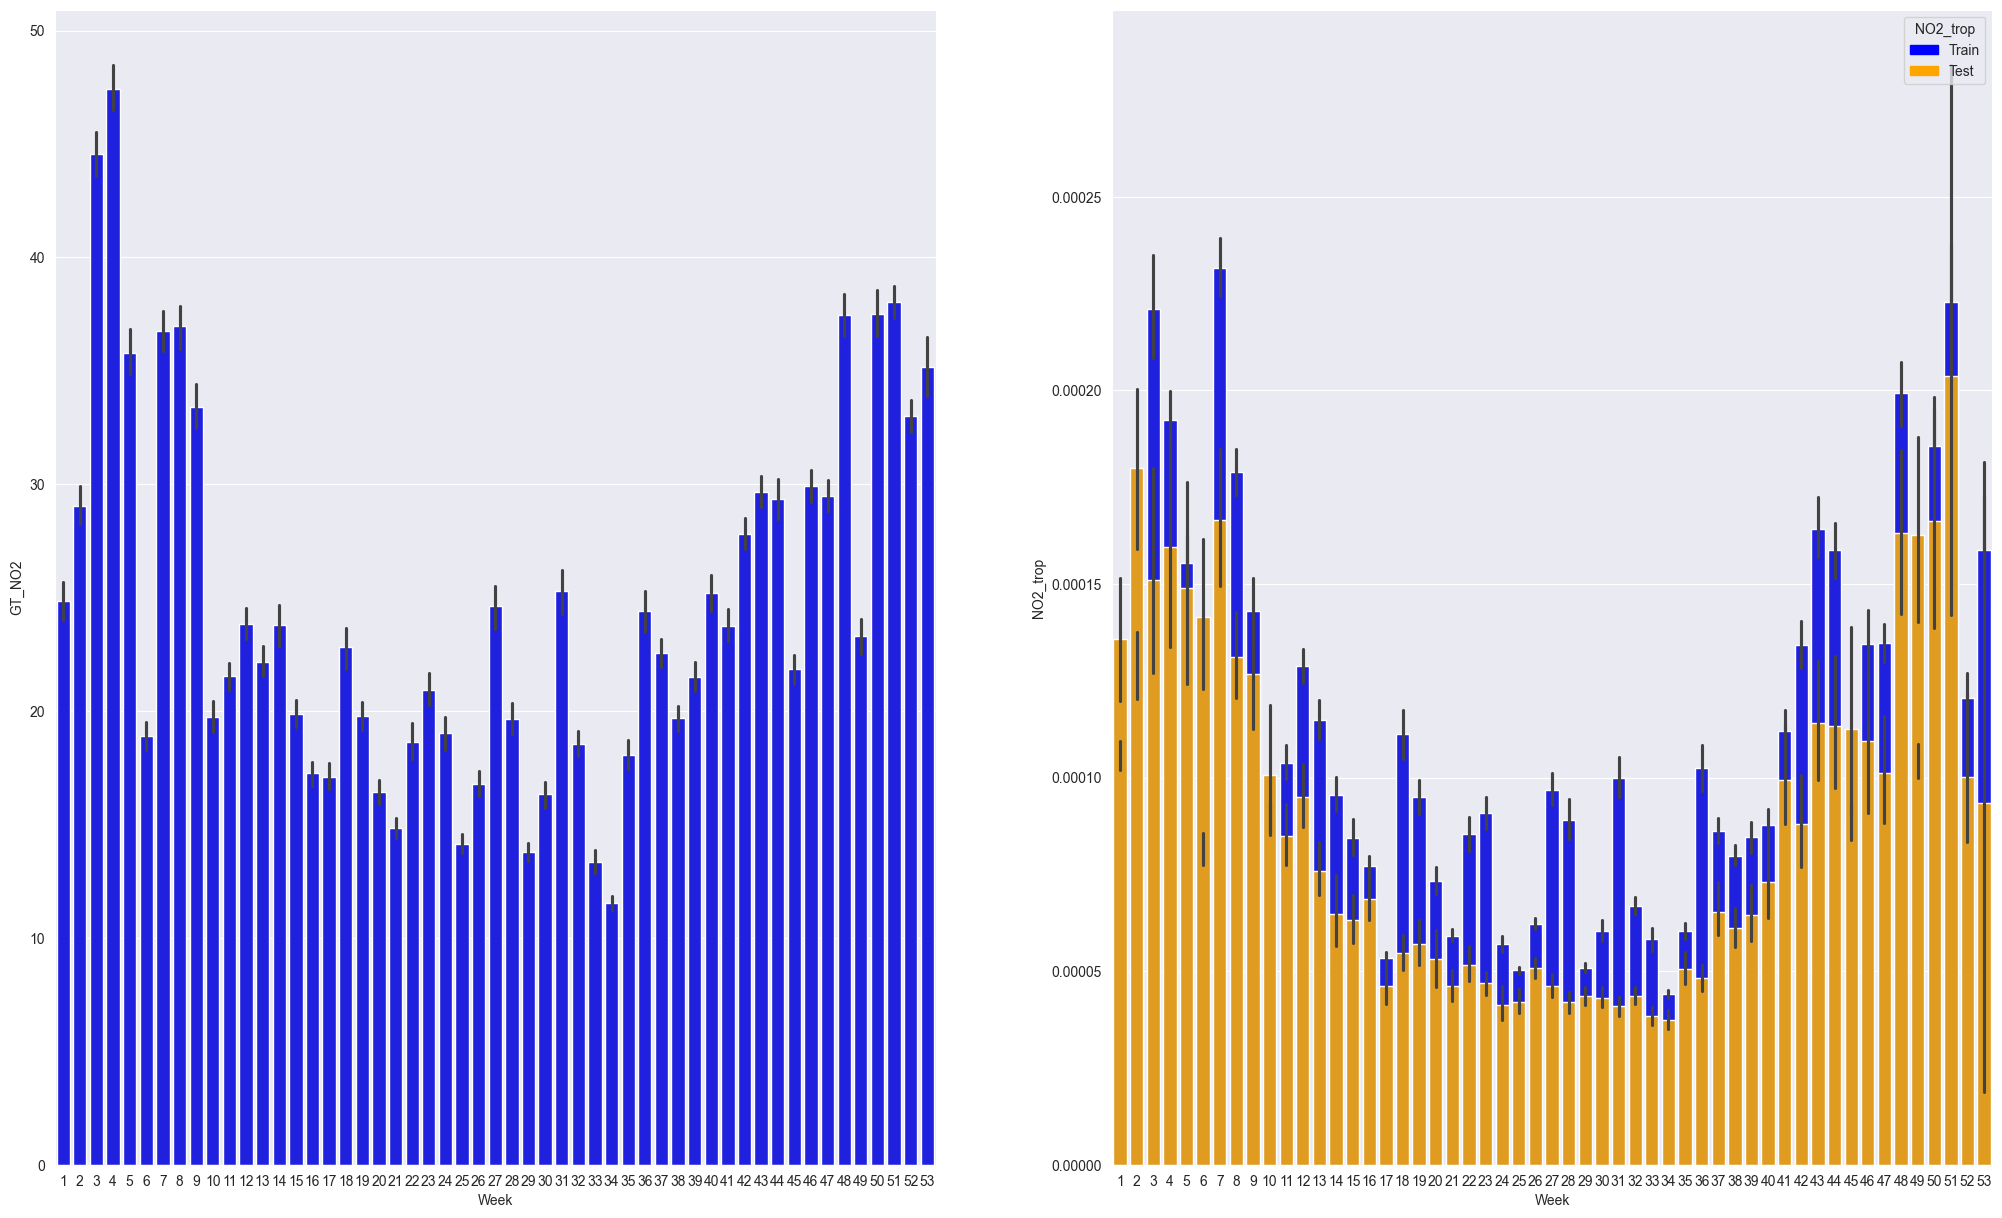

In [9]:
compare_plots('Week')

### Target values in seasons

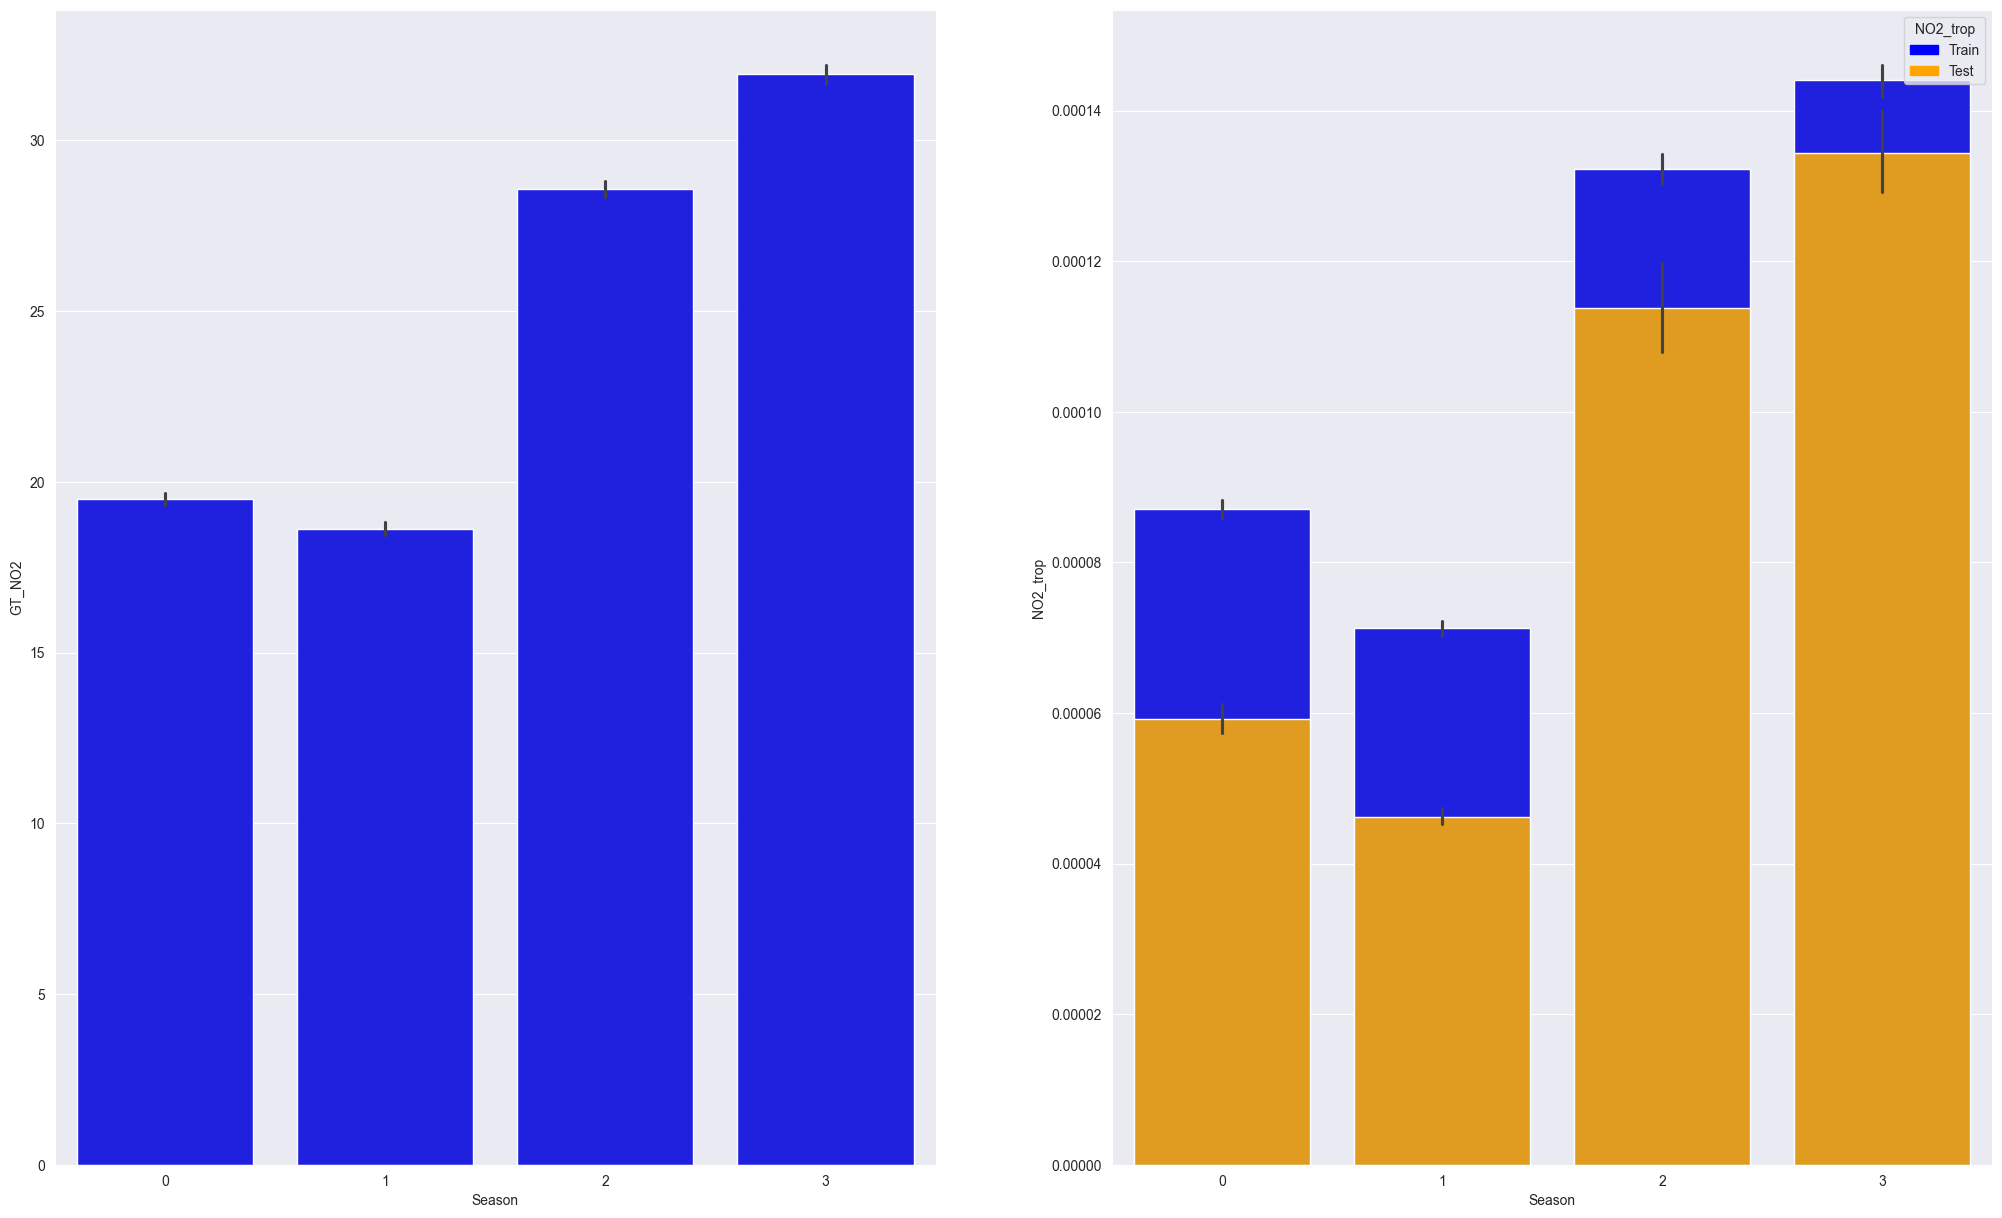

In [10]:
compare_plots('Season')

### Map of id's in train dataset

In [ ]:
import folium


my_map = folium.Map(
    location=(train['LAT'].mean(), train['LON'].mean()),
    zoom_start=7,
)

### Train Locations

In [ ]:
unique_train_locations = train.groupby(['LAT', 'LON'])['GT_NO2'].mean().reset_index()
nans = train.loc[train['GT_NO2'].isna() == True, ['LAT', 'LON']].value_counts().to_frame().reset_index()
unique_train_locations = pd.merge(unique_train_locations, nans, on=['LAT', 'LON'], how='outer')
unique_train_locations.rename({'count': 'Nans'}, axis=1, inplace=True)
unique_train_locations['Nans'] = unique_train_locations['Nans'].apply(lambda x: round(x / 10.96, 2))

unique_train_locations

In [ ]:
layer_train_map = folium.FeatureGroup(name='Train Locations', show=False)
for index, row in unique_train_locations.iterrows():
    popup_html = f"""
    <div style="font-family: Arial; font-size: 14px;">
        <strong>Mean GT_NO2 level:</strong> {row["GT_NO2"]:.2f}<br>
        <strong>Latitude:</strong> {row["LAT"]}<br>
        <strong>Longitude:</strong> {row["LON"]}<br>
        <strong>Percent of nans:</strong> {row['Nans']} %
    </div>
    """
    popup = folium.Popup(popup_html, max_width=300)
    if row['Nans'] > 10:
        folium.Marker(
            location=[row['LAT'], row['LON']],
            icon=folium.Icon(color='green', icon_color='black', icon='home'),
            popup=popup,
        ).add_to(layer_train_map)
    else:
        folium.Marker(
            location=[row['LAT'], row['LON']],
            icon=folium.Icon(color='green', icon='home'),
            popup=popup,
        ).add_to(layer_train_map)
    
layer_train_map.add_to(my_map)

### Test Locations

In [ ]:
unique_test_locations = test[['LAT', 'LON']].drop_duplicates()

layer_test_map = folium.FeatureGroup(name='Test Locations', show=False)
for index, row in unique_test_locations.iterrows():
    popup_html = f"""
    <div style="font-family: Arial; font-size: 14px;">
        <strong>Latitude:</strong> {row["LAT"]}<br>
        <strong>Longitude:</strong> {row["LON"]}
    </div>
    """
    popup = folium.Popup(popup_html, max_width=300)
    folium.Marker(
        location=[row['LAT'], row['LON']],
        icon=folium.Icon(color='red', icon='home'),
        popup=popup,
    ).add_to(layer_test_map)
    
layer_test_map.add_to(my_map)

In [ ]:
folium.LayerControl().add_to(my_map)
my_map.save('my_map.html')

### Prepare data

In [ ]:
test_ids = test['ID_Zindi']
train.drop(columns=['ID', 'ID_Zindi'], axis=1, inplace=True)
test.drop(columns=['ID', 'ID_Zindi'], axis=1, inplace=True)

### Fill NO2_trop with diff between NO2_total and NO2_strat

In [ ]:
# train_random_num = np.random.uniform(-1e-6, 1e-6, size=len(train))
# test_random_num = np.random.uniform(-1e-6, 1e-6, size=len(test))
# train.fillna({'NO2_trop': train['NO2_total'] - train['NO2_strat'] + train_random_num}, inplace=True)
# test.fillna({'NO2_trop': test['NO2_total'] - test['NO2_strat'] + test_random_num}, inplace=True)

### Get elevation from LAT, LON

In [ ]:
import requests

def get_elevation(lat, lon):
    query = f'https://api.open-elevation.com/api/v1/lookup?locations={lat},{lon}'
    r = requests.get(query).json()
    return r['results'][0]['elevation']


unique_train_locations['Elevation'] = unique_train_locations.apply(lambda r: get_elevation(r['LAT'], r['LON']), axis=1)
unique_test_locations['Elevation'] = unique_test_locations.apply(lambda r: get_elevation(r['LAT'], r['LON']), axis=1)
unique_train_locations.drop(columns=['Nans', 'GT_NO2'], inplace=True)

train = train.merge(unique_train_locations, on=['LAT', 'LON'], how='left')
test = test.merge(unique_test_locations, on=['LAT', 'LON'], how='left')

### Check ranges of values

In [ ]:
train.describe()

### Make the same ranges for test and train

In [ ]:
def cut_ranges():
    for column in test.select_dtypes(exclude=['category']).columns[2:]:
        test_min = test[column].min()
        test_max = test[column].max()
        to_drop = train[(train[column] < test_min) | (train[column] > test_max)].index
        train.drop(index=to_drop, inplace=True)


cut_ranges()

train.describe()

### Correlation Matrix for train

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(train.corr().round(2), annot=True, cmap='Greys')

### Correlation Matrix for test

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(test.corr().round(2), annot=True, cmap='Greys')

### Scatter plots of columns from original dataset

In [ ]:
def plot_scatter():
    columns = train.columns.values[:10]
    fig, ax = plt.subplots(nrows=len(columns) // 5, ncols=5, figsize=(25, 15))
    for i, col in enumerate(columns):
        x_cord, y_cord = divmod(i, 5)
        sns.scatterplot(data=train, x=col, y='GT_NO2', ax=ax[x_cord, y_cord], s=2)
        ax[x_cord, y_cord].set_title(f'Correlation between {col} and GT_NO2')
        ax[x_cord, y_cord].set_xlabel(col)
        ax[x_cord, y_cord].set_ylabel('GT_NO2')


plot_scatter()

### Do sth with NaNs in GT_NO2

train lightgbm to fill NaNs in train df
filled rows use for final training, or drop

In [ ]:
# gt_no2_nans = train.loc[train['GT_NO2'].isna() == True, :]
train.dropna(subset=['GT_NO2'], inplace=True)
train.reset_index(drop=True, inplace=True)

### Distribution of values

In [ ]:
train['GT_NO2'].plot(kind='hist')

### Identify outliers in target column using zscore

In [ ]:
from scipy.stats import zscore


def show_outliers(data, up, down, num):
    outliers = zscore(data)
    
    quantiles = pd.DataFrame(list(zip(np.linspace(up, down, num), [np.quantile(outliers, el) for el in np.linspace(up, down, num)], [np.quantile(data, el) for el in np.linspace(up, down, num)])), columns=['quantile', 'zscore', data.name])
    
    return quantiles

show_outliers(train['GT_NO2'], 0.98, 1, 21)

In [ ]:
show_outliers(train['GT_NO2'], 0.0, 0.1, 21)

### Deleting outliers in top 1.4% percentile

In [ ]:
def detect_outliers(data, down, up):
    outliers = zscore(data)
    to_drop = []
    q1, q2 = np.quantile(outliers, down), np.quantile(outliers, up)
    for i, el in enumerate(outliers):
        if el > q2:
            to_drop.append(i)
    return to_drop

def delete_outliers(indexes, df):
    df.reset_index(drop=True, inplace=True)
    df.drop(indexes, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

indexes_to_drop = detect_outliers(train['GT_NO2'], 0.0, 0.986)
train = delete_outliers(indexes_to_drop, train)

train.info()

### Save data

In [ ]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

### Training process

In [ ]:
from sklearn.model_selection import train_test_split


X, y = train.drop(columns=['GT_NO2'], axis=1), train['GT_NO2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [ ]:
import lightgbm as lgb
import optuna
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import cross_val_score, GroupKFold
from catboost import CatBoostRegressor

### LightGBM

In [ ]:
def define_lightgbm(trial):
    params = {
        'max_bin': trial.suggest_int('max_bin', 70, 250),
        'num_leaves': trial.suggest_int('num_leaves', 150, 400),
        'max_depth': trial.suggest_int('max_depth', 6, 15),
        'learning_rate': trial.suggest_float('learning_rate', 2e-3, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 400, 700),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.8, log=True),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 100, 400),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-2, 1, log=True),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 5),
        'objective': 'root_mean_squared_error',
        'boosting_type': 'gbdt',
        'tree_learner': 'voting',
        'device': 'cpu',
        'n_jobs': -1,
        'random_state': 4,
        'verbosity': -1,
    }
    return lgb.LGBMRegressor(**params)

def objective_lightgbm(trial):
    model = define_lightgbm(trial)
    gkf = GroupKFold(n_splits=X['Month'].nunique())
    scores = cross_val_score(model, X, y, groups=X['Month'], cv=gkf, n_jobs=-1, scoring='neg_root_mean_squared_error')
    return scores.mean() * (-1)

### CatBoost

In [ ]:
def define_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 400),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'depth': trial.suggest_int('depth', 5, 12),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0, log=True),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.4, 1.0, log=True),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'random_state': 4,
        'cat_features': ['Season', 'DayOfWeek', 'Week', 'Year', 'Month'],
    }
    return CatBoostRegressor(**params, silent=True)

def objective_catboost(trial):
    model = define_catboost(trial)
    gkf = GroupKFold(n_splits=X['Season'].nunique())
    scores = cross_val_score(model, X, y, groups=X['Season'], cv=gkf, n_jobs=-1, scoring='neg_root_mean_squared_error')
    return scores.mean() * (-1)

### LightGBM study

In [ ]:
study_lightgbm = optuna.create_study(direction='minimize', study_name='GeoAIWithLightGBM', sampler=optuna.samplers.TPESampler())
study_lightgbm.optimize(objective_lightgbm, n_trials=100)

### CatBoost study

In [ ]:
study_catboost = optuna.create_study(direction='minimize', study_name='GeoAIWithCatBoost', sampler=optuna.samplers.TPESampler())
study_catboost.optimize(objective_catboost, n_trials=100)

### Narazie najlepszy model ever

In [ ]:
best_params =  {'max_bin': 84, 'num_leaves': 269, 'max_depth': 11, 'learning_rate': 0.009567724370102485, 'n_estimators': 621, 'bagging_fraction': 0.6947463877737182, 'colsample_bytree': 0.40279034207476644, 'min_data_in_leaf': 111, 'reg_lambda': 0.14810770431354064, 'bagging_freq': 1, 'device': 'cpu', 'n_jobs': -1, 'random_state': 4, 'verbosity': -1, 'tree_learner': 'voting', 'objective': 'root_mean_squared_error', 'boosting_type': 'gbdt'}

lgb_model = lgb.LGBMRegressor(**best_params)
lgb_model.fit(X, y)

### Po optunie

In [ ]:
lgb_model = define_lightgbm(study_lightgbm.best_trial)
lgb_model.fit(X, y)

In [ ]:
cat_model = define_catboost(study_catboost.best_trial)
cat_model.fit(X, y)

### Validate model
(just to be here)

In [ ]:
lightgbm_params = ['max_bin', 'num_leaves', 'max_depth', 'learning_rate', 'n_estimators', 'bagging_fraction', 'colsample_bytree', 'min_data_in_leaf']
lgb_pred = lgb_model.predict(X_test)
root_mean_squared_error(y_test, lgb_pred)

In [ ]:
from sklearn.model_selection import LearningCurveDisplay


LearningCurveDisplay.from_estimator(lgb_model, X, y, cv=GroupKFold(n_splits=X['DayOfWeek'].nunique()), groups=X['DayOfWeek'], n_jobs=-1, random_state=4, scoring='neg_root_mean_squared_error')

In [ ]:
from sklearn.model_selection import LearningCurveDisplay


LearningCurveDisplay.from_estimator(cat_model, X, y, cv=GroupKFold(n_splits=X['DayOfWeek'].nunique()), groups=X['DayOfWeek'], n_jobs=-1, random_state=4, scoring='neg_root_mean_squared_error')

### Best params

In [ ]:
study_lightgbm.best_params

In [ ]:
study_catboost.best_params

In [ ]:
def save_to_csv(y_pred, save_as):
    if 'result' not in os.listdir(os.getcwd()):
        os.mkdir('result')
    final_df = pd.concat([test_ids, pd.DataFrame.from_dict({'GT_NO2': y_pred})], axis=1)
    final_df.to_csv(os.path.join('result', save_as), index=False)
    
save_to_csv(lgb_model.predict(test), 'lightgbm.csv')

In [ ]:
lgb.plot_importance(lgb_model, figsize=(20, 12), dpi=200)

In [ ]:
lgb.plot_tree(lgb_model, precision=2, figsize=(20, 12), show_info=['data_percentage'], dpi=600, orientation='vertical')

In [ ]:
xd = pd.read_csv(os.path.join('result', 'lightgbm.csv'), header=0)
xd['GT_NO2'] *= 0.94
xd.to_csv(os.path.join('result', 'lightgbm_even_better.csv'), index=False)

In [ ]:
predictions = 0.5 * lgb_model.predict(test) + 0.5 * cat_model.predict(test)

save_to_csv(predictions, 'cat_lgb_fifty_fifty.csv')